In [ ]:
import numpy as np

# queueing example
class Queue:
  def __init__(self,
               buffer_size = 20,
               prob_arrival = 0.5,
               prob_fast_service = 0.7,
               prob_slow_service = 0.4):
    self.buffer_size = buffer_size
    self.prob_arrival = prob_arrival
    self.prob_fast_service = prob_fast_service
    self.prob_slow_service = prob_slow_service
    self.queue_length = 0
  
  def step(self, action):
    arrival_token = np.random.binomial(1, self.prob_arrival)
    departure_token = np.random.binomial(1, self.prob_fast_service if action=='fast' else self.prob_slow_service)
    abandonment = max(self.queue_length + arrival_token - departure_token - self.buffer_size, 0)
    self.queue_length = max(min(self.queue_length + arrival_token - departure_token, self.buffer_size), 0)
    observation = (self.queue_length, abandonment)
    return observation

  def transition_probs(self, queue_length, action):
    prob_departure = self.prob_fast_service if action=='fast' else self.prob_slow_service
    prob_increase = self.prob_arrival * (1-prob_departure) if queue_length < self.buffer_size else 0.0
    prob_decrease = (1-self.prob_arrival) * prob_departure if queue_length > 0 else 0.0
    prob_same = 1 - prob_increase - prob_decrease
    prob_abandonment = 0 if queue_length<self.buffer_size else self.prob_arrival*(1-prob_departure)
    return prob_decrease, prob_same, prob_increase, prob_abandonment

def reward(action, observation, fast_cost=30.0, slow_cost=0.0, abandonment_cost=500):
  length = observation[0]
  abandonment = observation[1]
  return -length - abandonment * abandonment_cost - (fast_cost if action=='fast' else slow_cost)

['slow', 'slow', 'slow', 'slow', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast']


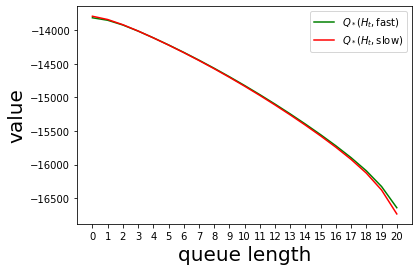

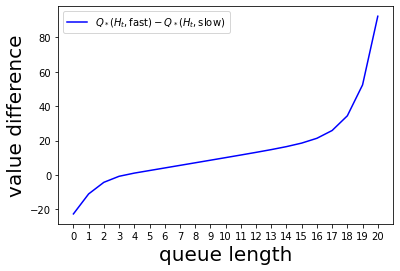

In [ ]:
## plan via value iteration
queue = Queue()
T = 1000

# compute optimal action value function
action_list = ['fast','slow']
Q = {a:np.zeros(queue.buffer_size+1) for a in action_list}
for iter in range(T):
  Q_update = {a:np.zeros(queue.buffer_size+1) for a in action_list}
  for a in action_list:
    for queue_length in range(queue.buffer_size+1):
      prob_decrease, prob_same, prob_increase, prob_abandonment = queue.transition_probs(queue_length, a)
      V = np.maximum.reduce([Q[b] for b in action_list])
      Q_next = prob_decrease * V[max(queue_length-1,0)] + prob_same * V[queue_length] + prob_increase * V[min(queue_length+1, queue.buffer_size)]
      Q_update[a][queue_length] = (1-prob_abandonment) * reward(a, (queue_length, 0)) + prob_abandonment * reward(a, (queue_length, 1)) + Q_next
  Q = Q_update

# report optimal policy
policy = (queue.buffer_size + 1) * [None] 
for length in range(len(policy)):
  policy[length] = action_list[np.argmax([Q[a][length] for a in action_list])]
print(policy)

# plot optimal value function
import matplotlib.pyplot as plt
import pylab
queue_lengths = range(queue.buffer_size+1)
plt.plot(queue_lengths, [q for q in Q['fast']], 'green', label=r'$Q_*(H_t, \mathrm{fast})$')
plt.plot(queue_lengths, [q for q in Q['slow']], 'red', label=r'$Q_*(H_t, \mathrm{slow})$')
plt.xticks(queue_lengths)
plt.xlabel(r'queue length', fontsize=20)
plt.ylabel('value', fontsize=20)
pylab.legend(loc='best')
plt.show()

# plot difference between value functions
import matplotlib.pyplot as plt
import pylab
queue_lengths = range(queue.buffer_size+1)
plt.plot(queue_lengths, [q_fast-q_slow for (q_fast,q_slow) in zip(Q['fast'],Q['slow'])], 'blue', label = r'$Q_*(H_t, \mathrm{fast}) - Q_*(H_t, \mathrm{slow})$')
plt.xticks(queue_lengths)
plt.xlabel(r'queue length', fontsize=20)
plt.ylabel('value difference', fontsize=20)
pylab.legend(loc='best')
plt.show()

# cache value function
V_optimal = np.maximum.reduce([Q[b] for b in action_list])

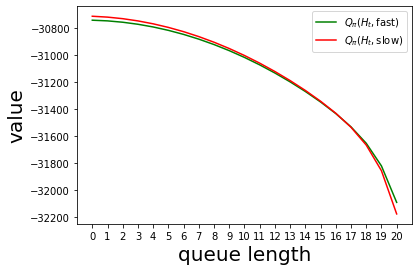

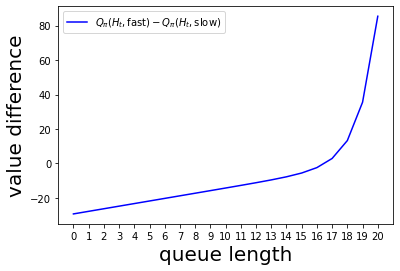

In [ ]:
## compute policy value function for policy that always selects fast mode
queue = Queue()
T = 1000

# compute policy value function
action_list = ['fast','slow']
Q = {a:np.zeros(queue.buffer_size+1) for a in action_list}
for iter in range(T):
  Q_update = {a:np.zeros(queue.buffer_size+1) for a in action_list}
  for a in action_list:
    for queue_length in range(queue.buffer_size+1):
      prob_decrease, prob_same, prob_increase, prob_abandonment = queue.transition_probs(queue_length, a)
      Q_next = prob_decrease * Q['fast'][max(queue_length-1,0)] + prob_same * Q['fast'][queue_length] + prob_increase * Q['fast'][min(queue_length+1, queue.buffer_size)]
      Q_update[a][queue_length] = (1-prob_abandonment) * reward(a, (queue_length, 0)) + prob_abandonment * reward(a, (queue_length, 1)) + Q_next
  Q = Q_update

# plot policy value function
import matplotlib.pyplot as plt
import pylab
queue_lengths = range(queue.buffer_size+1)
plt.plot(queue_lengths, [q for q in Q['fast']], 'green', label=r'$Q_\pi(H_t, \mathrm{fast})$')
plt.plot(queue_lengths, [q for q in Q['slow']], 'red', label=r'$Q_\pi(H_t, \mathrm{slow})$')
plt.xticks(queue_lengths)
plt.xlabel(r'queue length', fontsize=20)
plt.ylabel('value', fontsize=20)
pylab.legend(loc='best')
plt.show()

# plot difference between value functions
import matplotlib.pyplot as plt
import pylab
queue_lengths = range(queue.buffer_size+1)
plt.plot(queue_lengths, [q_fast-q_slow for (q_fast,q_slow) in zip(Q['fast'],Q['slow'])], 'blue', label='$Q_\pi(H_t, \mathrm{fast}) - Q_\pi(H_t, \mathrm{slow})$')
plt.xticks(queue_lengths)
plt.xlabel(r'queue length', fontsize=20)
plt.ylabel('value difference', fontsize=20)
pylab.legend(loc='best')
plt.show()

# cache value function
V_fast = Q['fast'].copy()

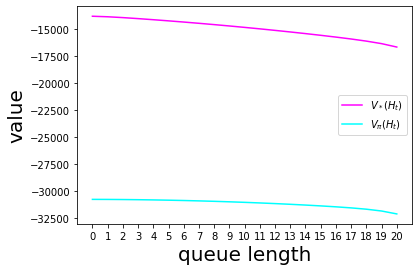

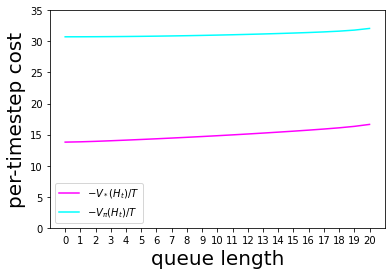

In [ ]:
# compare value function of policy that always applies fast mode versus optimal value function

# plot value functions
import matplotlib.pyplot as plt
import pylab
queue_lengths = range(queue.buffer_size+1)
plt.plot(queue_lengths, V_optimal, 'magenta', label=r'$V_*(H_t)$')
plt.plot(queue_lengths, V_fast, 'cyan', label=r'$V_\pi(H_t)$')
plt.xticks(queue_lengths)
plt.xlabel(r'queue length', fontsize=20)
plt.ylabel('value', fontsize=20)
pylab.legend(loc='best')
plt.show()

# plot value functions
import matplotlib.pyplot as plt
import pylab
queue_lengths = range(queue.buffer_size+1)
plt.plot(queue_lengths, [-v/T for v in V_optimal], 'magenta', label=r'$-V_*(H_t)/T$')
plt.plot(queue_lengths, [-v/T for v in V_fast], 'cyan', label=r'$-V_\pi(H_t)/T$')
plt.xticks(queue_lengths)
plt.yticks(range(0, 36, 5))
plt.xlabel(r'queue length', fontsize=20)
plt.ylabel('per-timestep cost', fontsize=20)
pylab.legend(loc='best')
plt.show()

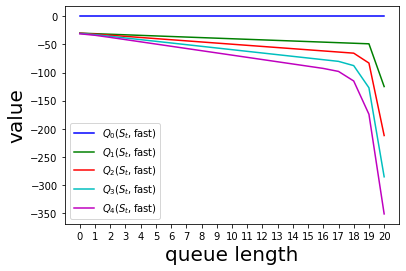

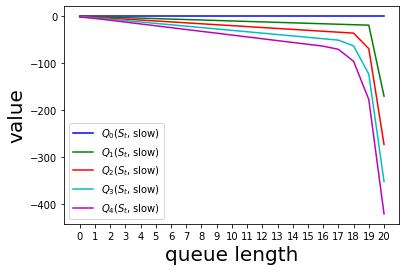

In [ ]:
## plot iterates generated by discounted value iteration
queue = Queue()
T = 5
discount = 0.99

# compute optimal action value function
action_list = ['fast','slow']
Q = {a:np.zeros(queue.buffer_size+1) for a in action_list}
Qiter = [{a:np.zeros(queue.buffer_size+1) for a in action_list} for i in range(T)]
for iter in range(T):
  Q_update = {a:np.zeros(queue.buffer_size+1) for a in action_list}
  for a in action_list:
    for queue_length in range(queue.buffer_size+1):
      prob_decrease, prob_same, prob_increase, prob_abandonment = queue.transition_probs(queue_length, a)
      V = np.maximum.reduce([Q[b] for b in action_list])
      Q_next = prob_decrease * V[max(queue_length-1,0)] + prob_same * V[queue_length] + prob_increase * V[min(queue_length+1, queue.buffer_size)]
      Q_update[a][queue_length] = (1-prob_abandonment) * reward(a, (queue_length, 0)) + prob_abandonment * reward(a, (queue_length, 1)) + discount * Q_next
    Qiter[iter][a] = Q[a].copy()
  Q = Q_update


# plot iterates
import matplotlib.pyplot as plt
import pylab
colors = {0: 'b',
          1: 'g',
          2: 'r',
          3: 'c',
          4: 'm',
          5: 'y'}
queue_lengths = range(queue.buffer_size+1)
for iter in range(T):
  plt.plot(queue_lengths, [q for q in Qiter[iter]['fast']], colors[iter], label=r'$Q_'+ str(iter) + '(S_t, \mathrm{fast})$')
plt.xticks(queue_lengths)
plt.xlabel(r'queue length', fontsize=20)
plt.ylabel('value', fontsize=20)
pylab.legend(loc='best')
plt.show()
for iter in range(T):
  plt.plot(queue_lengths, [q for q in Qiter[iter]['slow']], colors[iter], label=r'$Q_' + str(iter) + '(S_t, \mathrm{slow})$')
plt.xticks(queue_lengths)
plt.xlabel(r'queue length', fontsize=20)
plt.ylabel('value', fontsize=20)
pylab.legend(loc='best')
plt.show()

